In [1]:
import pyreadr
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
import numpy as np
import pandas as pd

import timeit

from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import mean_squared_error

from tqdm import tqdm
import graphviz
from xgboost import XGBClassifier
from xgboost import plot_tree

In [2]:
result = pyreadr.read_r('..\StJames_hab.rds')
df = result[None]
df['Wetland'] = np.where(df['Habitat']==2.0, 0, 1)
df

,Habitat,DEM,sDEM,hDEM,DSM,CHM,Aspect,Slope,Curvature,PlanCurv,ProfileCurv,NDVI,NDRE,NDWI,x,y,Wetland
0,1.0,18.596609,18.622410,18.596609,18.596609,0.000000,220.204926,0.282718,-7.620917,-7.436076,0.184842,0.740069,0.126273,-0.581894,689081.606492,23141.985899,1
1,1.0,18.852713,18.852713,18.852713,18.852713,0.000000,152.799408,1.943434,0.002119,0.001246,-0.000874,0.584242,0.125773,-0.588223,689061.811650,23140.486293,1
2,3.0,20.939791,21.091728,20.939791,23.523529,2.648577,337.529266,5.929980,-0.000000,-0.000000,0.000000,0.825232,0.204998,-0.667627,689063.611181,23114.393152,1
3,1.0,18.763475,18.600845,18.763475,20.473263,1.321201,262.127075,15.249783,0.004239,0.002263,-0.001976,0.459699,0.169193,-0.545694,689045.315949,23112.593625,1
4,1.0,18.332489,18.293556,18.379988,18.949297,0.000000,256.520172,15.954921,-13.741387,-3.217997,10.523391,0.631705,0.108272,-0.529282,689044.116261,23110.494177,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,2.0,16.185696,16.108330,16.319582,16.185696,0.000000,187.272522,1.815900,49.468147,20.895496,-28.572649,0.473911,0.121286,-0.534078,689054.313604,22178.939065,0
104,3.0,16.280769,15.979391,16.427000,18.946585,4.668274,143.560349,7.051764,152.568817,166.965775,14.396961,0.844496,0.263951,-0.678592,689005.726264,22136.350260,1
105,2.0,16.497171,16.600376,16.497171,16.496794,-0.000378,240.189713,7.700943,54.963428,13.395777,-41.567654,0.572507,0.131399,-0.559735,689130.793676,22133.051128,0
106,2.0,16.704000,16.905821,16.704000,16.704000,0.000000,330.354675,2.663709,-18.840366,25.873678,44.714043,0.175782,0.095512,-0.173850,689158.386486,22114.755937,0


In [3]:
# Models takes in X for co-variates, y for outcome. gridid is a series with all the gridids
def XGB(X, y, gridid):
    # acc_score holds accuracy of all cross-validation iterations. Used to compute mean accuracy
    acc_score = [];
    # contains all truth values for each grid
    Truth = [];
    # contains all output values for each grid
    Output = [];
    # dataframe of grid ids(same as gridid that's passed in)
    GRID_ID = pd.DataFrame(columns=['GRID_ID'])
    # 5 fold Cross-validation
    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    
    # tqdm tracks how many iterations are done(useful for calculating how long processing will take) but not used for anything else
    # train_index and test_index are the indexes of the splits within the cross validation
    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        # X_train and X_test are the values within the dataframe for the train and test indexes
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        # similar to X_train and y_train
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        # Get the grid id of the grid at the train index
        train_grid = gridid.iloc[train_index]
        # get the grid id of the grid at the test index 
        test_grid= gridid.iloc[test_index]
        
        # Assign a model
        model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)
 
        # Fit the model to the train and predict the test
        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        
        # Calculate the accuracy based on the predicted values
        acc = accuracy_score(y_test, pred_values)
        #Add the accuracy to the accuracy score array so we can take the average later
        acc_score.append(acc)
        
        # add the new grid(test_grid) to the data frame of gir ids
        GRID_ID = pd.merge(GRID_ID, test_grid, on='GRID_ID', how='outer')
        # add the truth values we calculated to the truth array with data from all cross validations
        #i'm not sure about the exact reason why we reshape the array though :/
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        ## add the output values, same way as above
        Output.extend(pred_values);
    
    ## calculate mean accuracy
    accuracy = np.mean(acc_score)
    ## Combine grid id, truth, and output so it can be returned
    output_df = pd.concat([GRID_ID, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    ## Calculate confusion matrix
    conf_mat = confusion_matrix(Truth, Output)
    ## Classification report
    class_rep = classification_report(Truth, Output, digits=4)
    ## Return outputs
    return output_df, accuracy, conf_mat, class_rep

In [4]:
def LGBM(X, y, coords):
    fig, ax = plt.subplots()
    tree_axs = []
    
    start_time = timeit.default_timer()

    kf = KFold(n_splits=5, random_state=2, shuffle=True)
    acc_score = [];
    Truth = [];
    Output = [];
    Coordinates = pd.DataFrame(columns=['x', 'y'])

    feature_importances = pd.DataFrame()
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train_index , test_index) in tqdm(enumerate(kf.split(df))):
        X_train , X_test = X.iloc[train_index,:], X.iloc[test_index,:]
        y_train , y_test = y.iloc[train_index], y.iloc[test_index]
        train_coord = coords.iloc[train_index]
        test_coord = coords.iloc[test_index]

        model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        
        t_ax = plot_tree(model, orientation='horizontal')
        tree_axs.append(t_ax)
        
        feature_importance = model.feature_importances_
        rel_imp = pd.DataFrame(feature_importance, index=X_train.columns, columns=[i])
        feature_importances = pd.concat([feature_importances, rel_imp], axis=1)

        viz = plot_roc_curve(model, X_test, y_test,
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        
        Coordinates = pd.merge(Coordinates, test_coord, on=['x', 'y'], how='outer')
        Truth.extend(y_test.values.reshape(y_test.shape[0])); ## it is a list
        Output.extend(pred_values);

    elapsed = timeit.default_timer() - start_time

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="ROC for StJames XGBM")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(loc="lower right")
    
    feature_importances['mean'] = feature_importances.iloc[:, 0:5].mean(axis=1)
    
    output_df = pd.concat([Coordinates, pd.DataFrame(Truth, columns=["Truth"]), pd.DataFrame(Output, columns=["Output"])], axis=1)
    return output_df, elapsed, confusion_matrix(Truth, Output), classification_report(Truth, Output, digits=4), acc_score, plt, feature_importances['mean'], tree_axs

5it [00:01,  3.77it/s]


1.331942399999999 seconds
[0.9545454545454546, 0.8181818181818182, 0.9545454545454546, 0.9047619047619048, 0.9523809523809523]
0.9168831168831169 accuracy
[[24  4]
 [ 5 75]]
              precision    recall  f1-score   support

           0     0.8276    0.8571    0.8421        28
           1     0.9494    0.9375    0.9434        80

    accuracy                         0.9167       108
   macro avg     0.8885    0.8973    0.8928       108
weighted avg     0.9178    0.9167    0.9171       108

<module 'matplotlib.pyplot' from 'c:\\Users\\shiti\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>


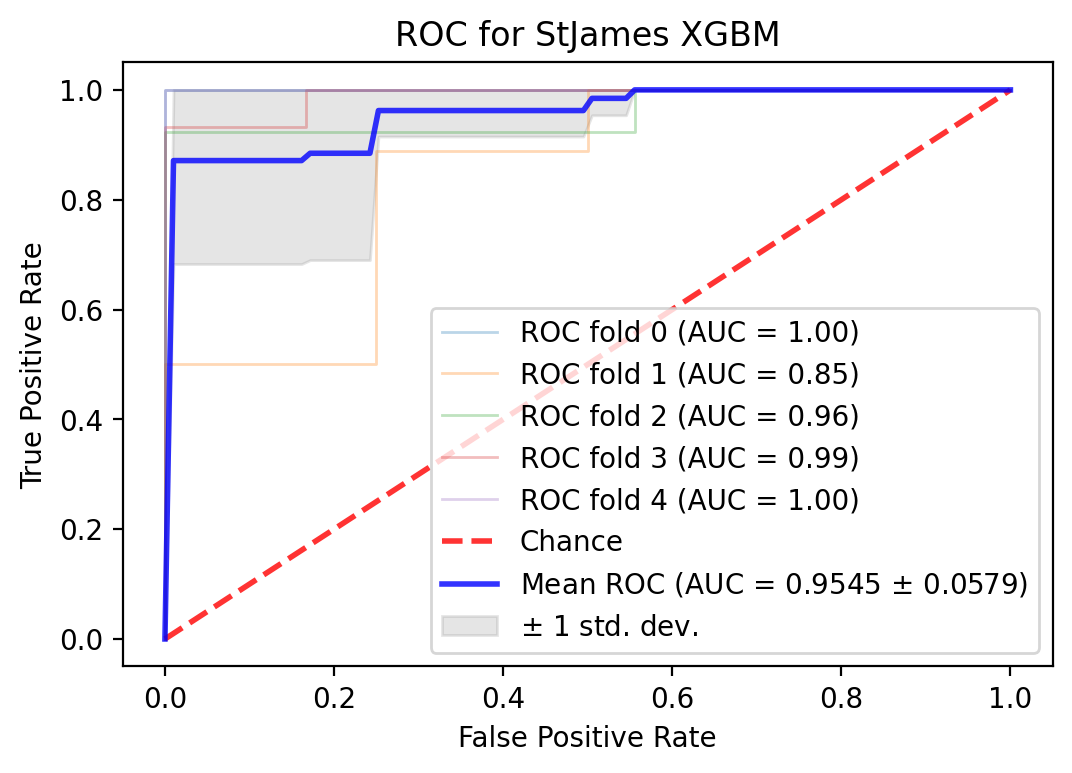

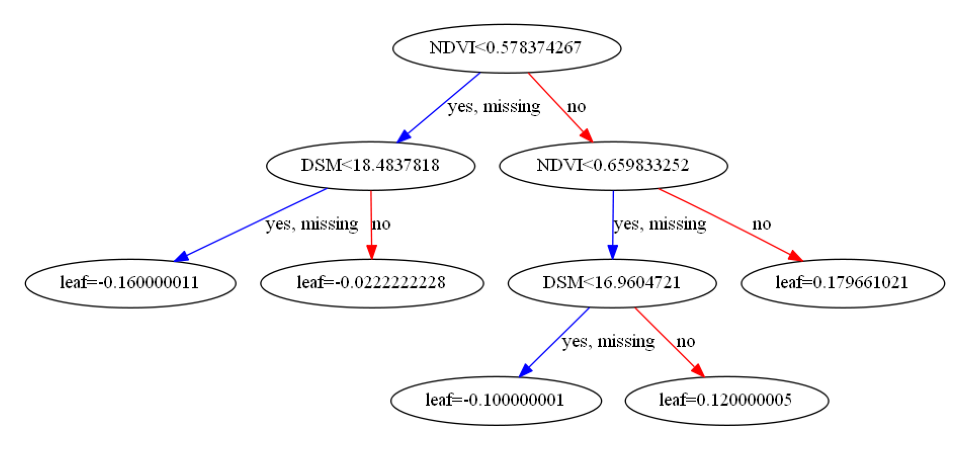

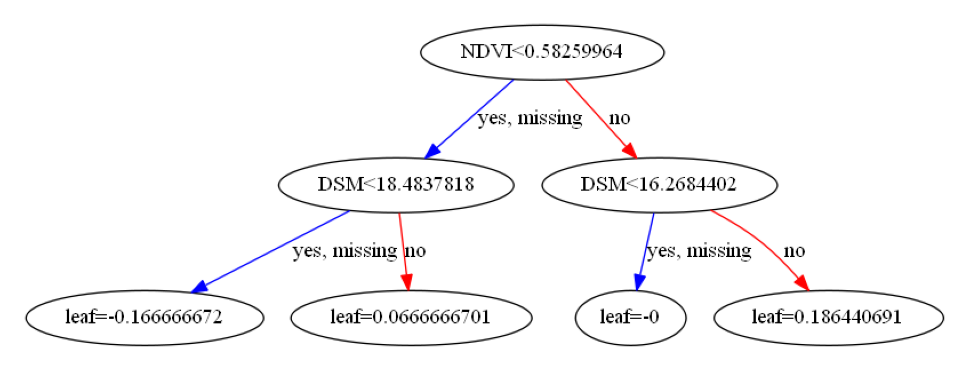

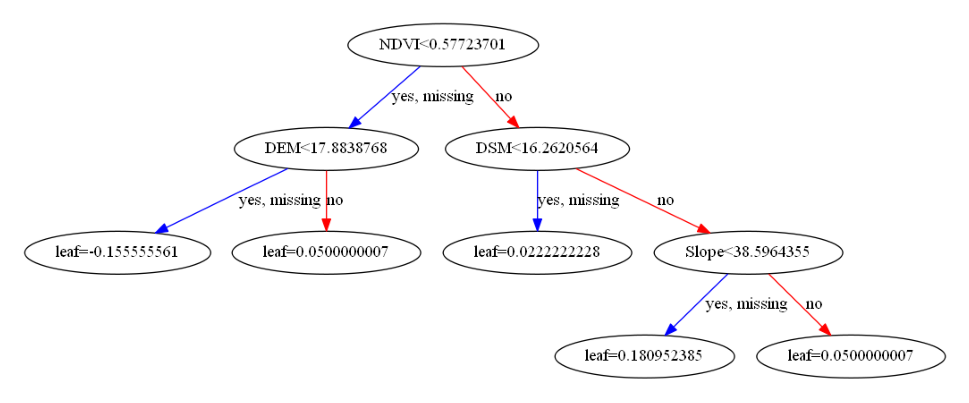

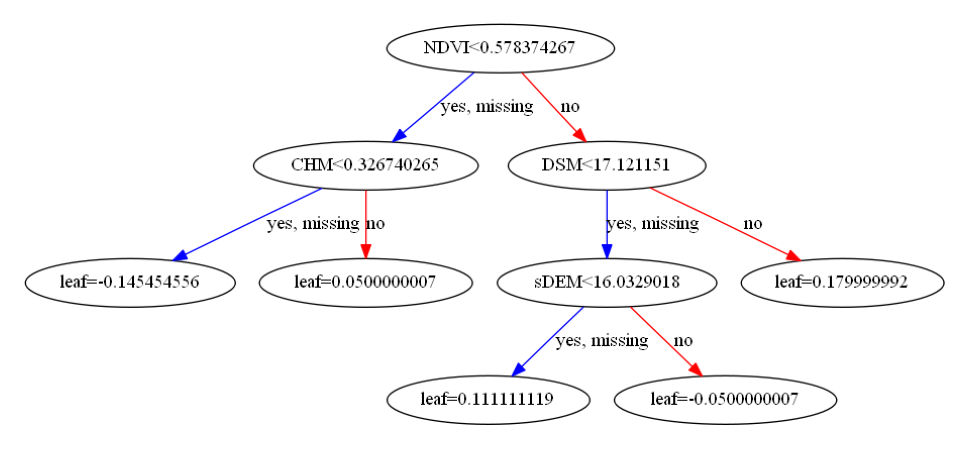

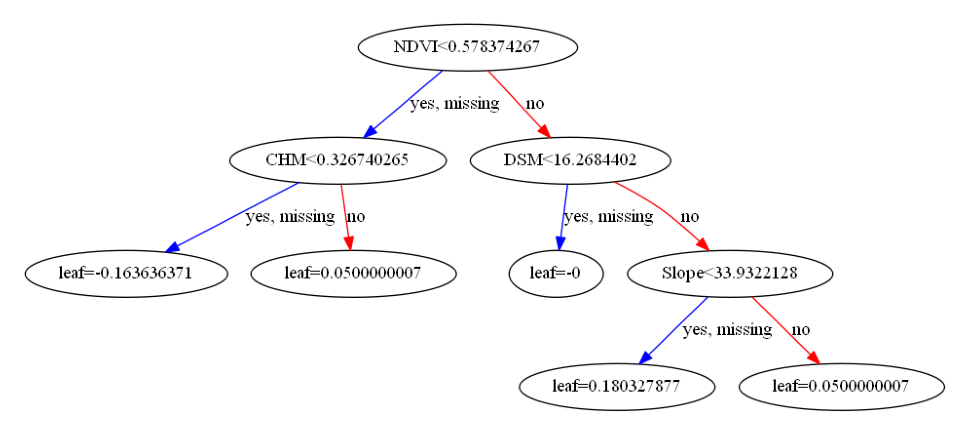

In [5]:
X = df.drop(['x', 'y', 'Habitat', 'Wetland'], axis=1)
y = df.Wetland
coords = df[['x', 'y']]
output_df, time, cm, cr, acc, roc, feat_imp, tree_axs = LGBM(X, y, coords)
print(f"{time} seconds")
print(f"{acc}")
print(f"{np.mean(acc)} accuracy")
print(cm)
print(cr)
print(roc)

Text(0.5, 1.0, 'Variable Importance for StJames XGBM')

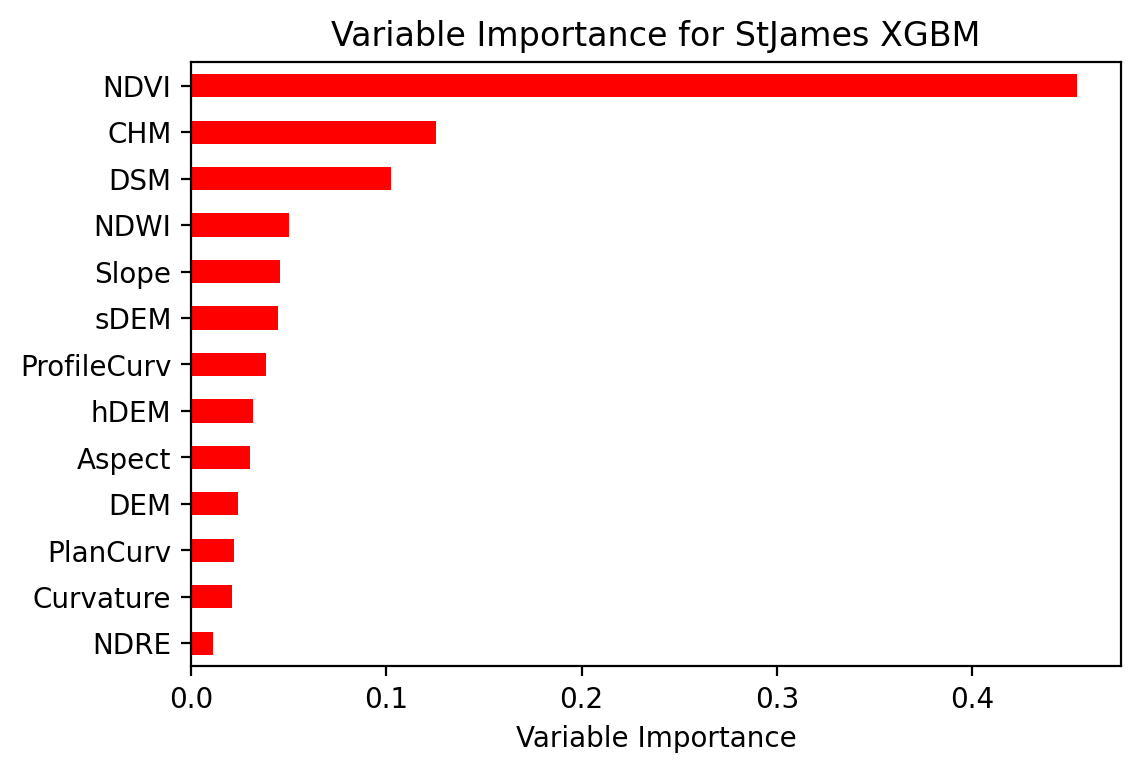

In [6]:
fig = feat_imp.sort_values()[-24:].T.plot(kind = 'barh', 
               color = 'r')
fig.set_xlabel("Variable Importance")
fig.set_title("Variable Importance for StJames XGBM")

In [7]:
result = pyreadr.read_r('..\StJames_all.rds')
df_all = result[None]

KeyboardInterrupt: 

Exception ignored in: 'pyreadr.librdata._handle_column'
Traceback (most recent call last):
  File "pyreadr\librdata.pyx", line 228, in pyreadr.librdata.Parser.__handle_column
  File "c:\Users\shiti\anaconda3\lib\enum.py", line 384, in __call__
    return cls.__new__(cls, value)
KeyboardInterrupt: 


In [9]:
X_all = df_all.drop(['x', 'y', 'Habitat'], axis=1)
coords_all = df_all[['x', 'y']]

Coords = coords_all
Output = []

In [10]:
model = XGBClassifier(n_estimators=500, learning_rate=0.1, max_depth=6 ,random_state=2)
model.fit(X, y)
pred_values = model.predict(X_all)
Output.extend(pred_values)

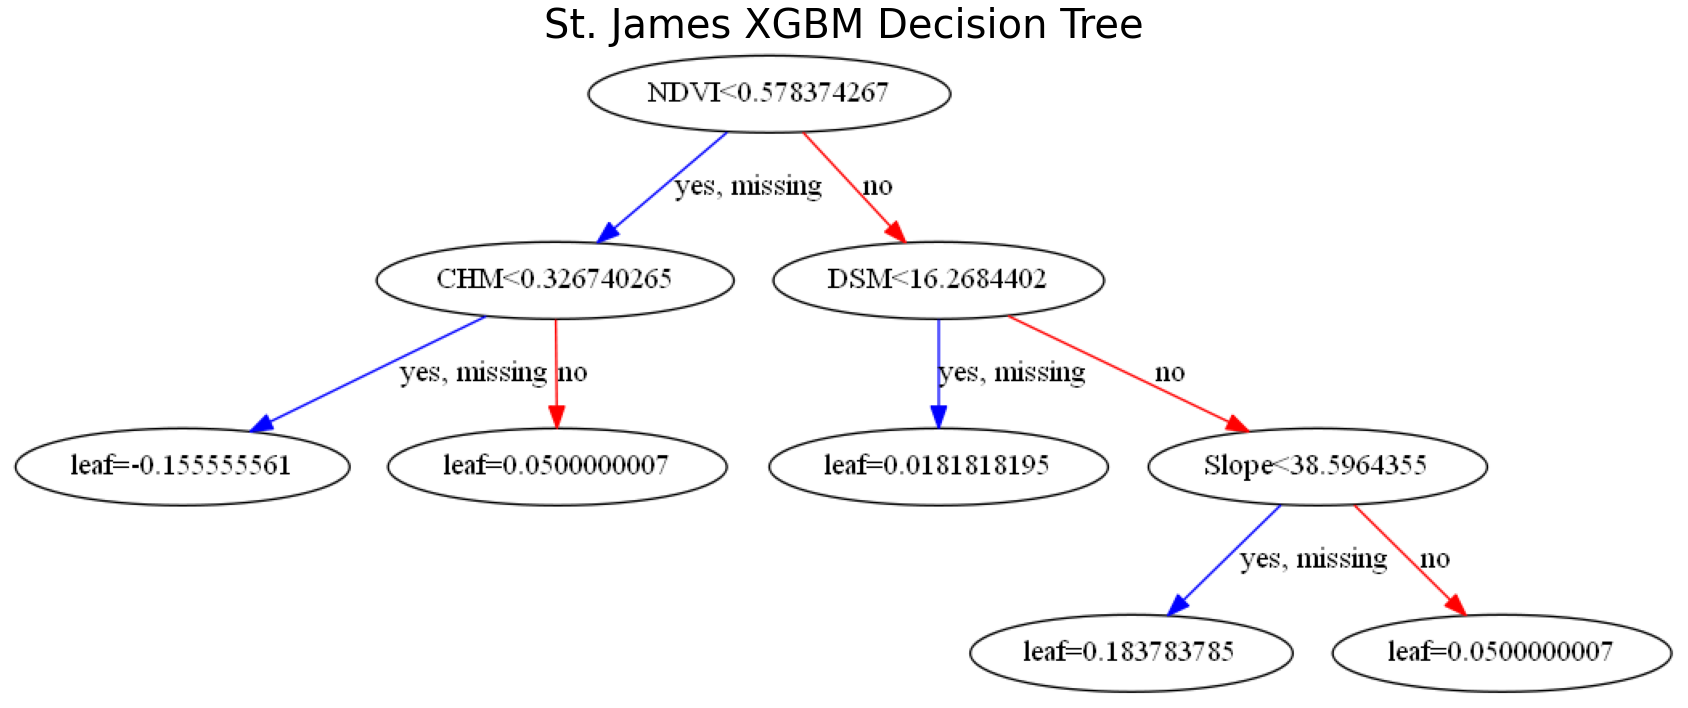

In [22]:
_, ax = plt.subplots(figsize=(30,30)) # Resize figure
plot_tree(model, filled=True, ax=ax, orientation='horizontal')
plt.title("St. James XGBM Decision Tree", fontsize=40)
plt.savefig('test.png', dpi=300)

In [15]:
test_df = pd.concat([Coords, pd.DataFrame(Output, columns=["Output"])], axis=1)

In [16]:
test_df.to_csv("../Comparison Data/StJamesXGB.csv", index=False)

In [17]:
test_df['Output'].value_counts()

1    6485306
0    1534500
Name: Output, dtype: int64